In [2]:
%cd /content/drive/MyDrive/Scribble Cardiac segmentation
%ls

/content/drive/MyDrive/Scribble Cardiac segmentation
data/  datasets/  models/  trainer/  training.ipynb  train_val_test_split.ipynb  utils/


In [ ]:
from albumentations import *
from albumentations.pytorch import *
from datasets.ACDC_dataset import BaseDataSets
import torch

train_both_aug = Compose([
        # PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0,p=1),
        RandomCrop(height=256, width=256, p=1),
        Cutout(num_holes=8,p=0.5),
        OneOf([
            ShiftScaleRotate(p=0.6),
            HorizontalFlip(p=0.8),
            VerticalFlip(p=0.8)
        ])
    ])


train_dataset = BaseDataSets(
    base_dir="data/ACDC/",
    split="train",
    transform_both = train_both_aug,
    transform_image=None
)

val_dataset = BaseDataSets(
    base_dir="data/ACDC/",
    split="val",
    transform_both = None,
    transform_image=None
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=12, shuffle=False)

total 1521 samples
total 190 samples


In [ ]:
train_dataset[0]['image'].shape, train_dataset[0]['label'].shape, train_dataset[0]['gt'].shape

(torch.Size([1, 256, 256]), torch.Size([256, 256]), torch.Size([256, 256]))

In [ ]:
val_dataset[0]['image'].shape, val_dataset[0]['label'].shape, val_dataset[0]['gt'].shape

(torch.Size([1, 256, 256]), torch.Size([256, 256]), torch.Size([256, 256]))

In [ ]:
# !pip install torchview
# import torchvision
# from torchview import draw_graph

# model_graph = draw_graph(model, input_size=(1,1,224,224), expand_nested=True)
# model_graph.visual_graph

In [3]:
%ls

data/  datasets/  models/  trainer/  training.ipynb  train_val_test_split.ipynb  utils/


In [4]:
%%writefile trainer/train_cct_net.py
import torch
from typing import List, Dict, Optional, Union, Tuple
from tqdm.auto import tqdm
import numpy as np
import sys
import torch.nn as nn
from typing import List, Dict, Optional, Union, Tuple
import random
#from utils.metrics import AverageMeter
from scipy.ndimage import zoom
from utils.metrics import AverageMeter

def train(
        epoch: int,
        loader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        model: torch.nn.Module,
        device: torch.device,
        criterion: Dict,
        weights: torch.tensor,
        prossesID: int = None
        ) -> Tuple[int, list]:

    model.train()

    prefix = 'Training'

    if prossesID is not None:
        prefix = "[{}]{}".format(prossesID, prefix)

    losses = AverageMeter()

    with tqdm(total=len(loader), ascii=True, desc=('{}: {:02d}'.format(prefix, epoch))) as pbar:
        for batch_i, sample in enumerate(loader, 0):

            # ================= Extract Data ==================
            batch_img = sample['image'].to(device)
            batch_label = sample['label'].to(device)

            # =================== forward =====================
            output, output_aux1 = model(batch_img)
            output_soft1 = torch.softmax(output, dim=1)
            output_soft2 = torch.softmax(output_aux1, dim=1)

            loss_ce1 = criterion['ce_loss'](output, batch_label[:].long())
            loss_ce2 = criterion['ce_loss'](output_aux1, batch_label[:].long())
            loss_ce = 0.5 * (loss_ce1 + loss_ce2)

            beta = random.random() + 1e-10

            pseudo_supervision = torch.argmax(
                (beta * output_soft1.detach() + (1.0-beta) * output_soft2.detach()), dim=1, keepdim=False)

            loss_pse_sup = 0.5 * (dice_loss(output_soft1, pseudo_supervision.unsqueeze(
                1)) + dice_loss(output_soft2, pseudo_supervision.unsqueeze(1)))

            loss = loss_ce + 0.5 * loss_pse_sup
            # =================== backward ====================
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            pbar.update()

            losses.update(loss.item(), batch_img.size(0))
            pbar.set_description(f"Epoch {epoch} - Trainig Loss: {losses.avg:.4f}")

    return losses


def validate(mode: str,
             epoch: int,
             loader: torch.utils.data.DataLoader,
             model: torch.nn.Module,
             device: torch.device,
             criterion: torch.nn.Module,
             weights: torch.tensor,
             prossesID: int = None
             ) -> Tuple[int, list]:

    model.eval()

    if mode == 'validation':
        prefix = 'Validating'
    elif mode == 'test':
        prefix = 'Testing'
    if prossesID is not None:
        prefix = "[{}]{}".format(prossesID, prefix)

    losses = AverageMeter()

    with torch.inference_mode():
        with tqdm(total=len(loader), ascii=True, desc=('{}: {:02d}'.format(prefix, epoch))) as pbar:
            for batch_i, sample in enumerate(loader, 0):

                # ================= Extract Data ==================
                batch_img = sample['image'].to(device)
                batch_gt = sample['gt'].to(device)

                # =================== forward =====================
                outputs = model(batch_img)[0]
                loss = criterion(outputs, batch_gt.long(), weights)

                # =================== backward ====================
                pbar.update()

                losses.update(loss.item(), batch_img.size(0))
                pbar.set_description(f"Epoch {epoch} - Val Loss: {losses.avg:.4f}")
    return losses

Writing trainer/train_cct_net.py


In [ ]:
from models.UNet_variants import UNet_CCT
from utils.losses import pDLoss, DiceLoss
from torch.nn.modules.loss import CrossEntropyLoss

In [ ]:
model = UNet_CCT(in_chns=1, class_num=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01,
                          momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)

ce_loss = CrossEntropyLoss(ignore_index=4)
dice_loss = pDLoss(4, ignore_index=4)
train_criterion = {'ce_loss': ce_loss, 'dice_loss': dice_loss}
val_criterion = pDLoss(4, ignore_index=4)

In [ ]:
epochs = 10
for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
    train_loss = train_cct_net(epoch, train_loader, optimizer, model, device, train_criterion, weights=None)
    scheduler.step()
    #val_loss = validate_cct_net("validation", epoch, val_loader, model, device, val_criterion, weights=None)
    #print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss.avg:.4f}, Val Loss: {val_loss.avg:.4f}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training: 01:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 02:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 03:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 04:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 05:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 06:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 07:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 08:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 09:   0%|          | 0/761 [00:00<?, ?it/s]

Training: 10:   0%|          | 0/761 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
def inference(dataset, idx, model, device):
    image = dataset[idx]['image'].unsqueeze(0)

    model.eval()

    with torch.no_grad():
        preds = torch.argmax(F.softmax(model(image.to(device))[0], dim=1), dim=1)
        mask_img = preds.squeeze(0)

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_img.cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(dataset[idx]['gt'].cpu(), cmap='gray')
    plt.axis('off')
    plt.show()

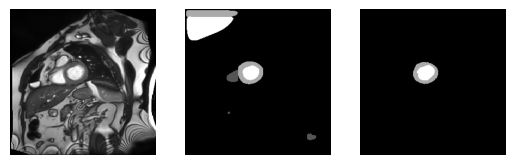

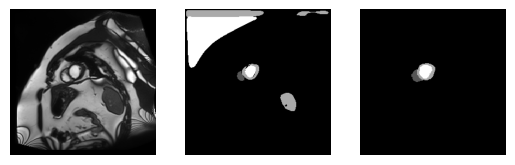

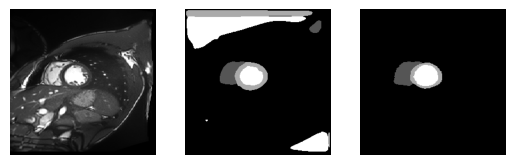

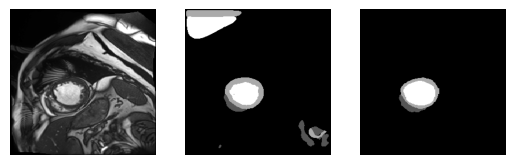

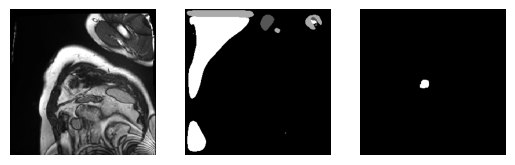

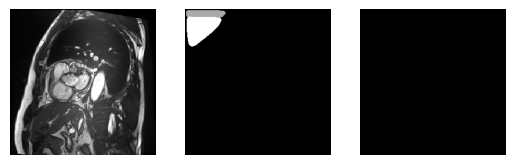

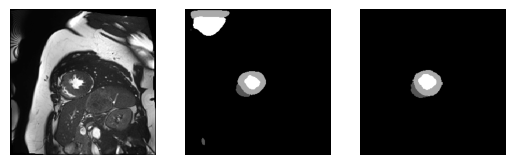

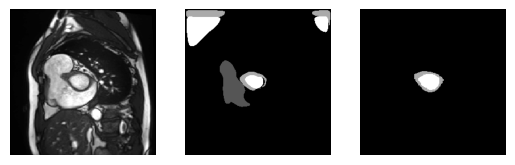

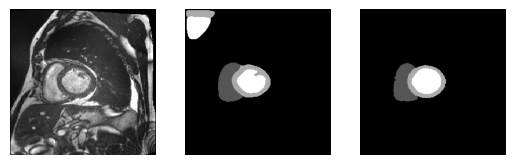

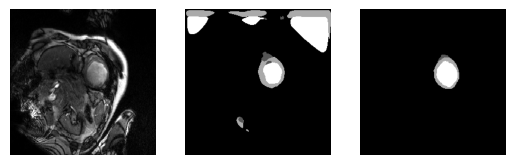

In [ ]:
import torch.nn.functional as F
import random
for i in range(10):
    idx = random.randint(0, len(val_dataset) - 1)
    inference(val_dataset, idx,model, device)